# Uso de Spark SQL

## Inicializaciones diversas

In [5]:
# Si ya existe, parar el SparkContext
# sc.stop()

In [4]:
import findspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

findspark.init()
sparkConf = SparkConf().setAppName("Flights SparkQL Application")
sc = SparkContext(conf=sparkConf)
spark = SparkSession(sc)

## Carga de datos y operaciones mediante API DataFrame

In [8]:
!wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/flights.csv

--2022-11-22 11:19:42--  https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/flights.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9719482 (9.3M) [text/plain]
Saving to: ‘flights.csv’

flights.csv         100%[===================>]   9.27M   964KB/s    in 8.0s    

2022-11-22 11:19:50 (1.16 MB/s) - ‘flights.csv’ saved [9719482/9719482]



In [9]:
#
# El archivo flights.csv se encuentra en la capeta de
# trabajo de la máquina local. Se copia el archivo
# a la carpeta /tmp del sistema HDFS.
#
!hdfs dfs -copyFromLocal flights.csv /tmp/

#
# Se listan los archivos en la carpeta /tmp del HDFS
# para verificar que el archivo haya sido copiado
#
!hdfs dfs -ls /tmp/*csv

-rw-r--r--   1 root supergroup    9719482 2022-11-22 11:19 /tmp/flights.csv


In [10]:
#
# Crea un DataFrame a partir del archivo fligths.csv
#
flights = spark.read.load("/tmp/flights.csv",
                          format="csv",
                          sep=",",
                          inferSchema="true",
                          header="true")

In [11]:
#
# Se imprime el esquema para verificar la lectura
# del archivo.
#
flights.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

In [12]:
#
# Se imprime un subconjunto de las columnas para verificar
# la lectura
#
flights.select(['UniqueCarrier', 'FlightNum', 'DepDelay', 'ArrDelay', 'Distance']).show(5)

+-------------+---------+--------+--------+--------+
|UniqueCarrier|FlightNum|DepDelay|ArrDelay|Distance|
+-------------+---------+--------+--------+--------+
|           WN|      335|       8|     -14|     810|
|           WN|     3231|      19|       2|     810|
|           WN|      448|       8|      14|     515|
|           WN|     1746|      -4|      -6|     515|
|           WN|     3920|      34|      34|     515|
+-------------+---------+--------+--------+--------+
only showing top 5 rows



In [17]:
#
# Número total de registros leidos
#
numTotalFlights = flights.count()
numTotalFlights

99999

In [18]:
#
# La variable delayedFlights contiene las columnas UniqueCarrier y DepDelay
# para los vuelos con DepDelay > 15 minutos.
#
delayedFlights = flights.select(['UniqueCarrier', 'DepDelay']).filter(flights['DepDelay'] > 15)
delayedFlights.show(5)

+-------------+--------+
|UniqueCarrier|DepDelay|
+-------------+--------+
|           WN|      19|
|           WN|      34|
|           WN|      25|
|           WN|      67|
|           WN|      94|
+-------------+--------+
only showing top 5 rows



In [19]:
#
# Calculamos el porcentaje de vuelos retrasados.
#
numDelayedFlights = delayedFlights.count()
print("Porcentaje de vuelos retrasados: " + str(numDelayedFlights / numTotalFlights * 100) + "%")

Porcentaje de vuelos retrasados: 19.58719587195872%


In [20]:
#
# Definición de un UDF (User-Defined Function). De momento solo  la definimos. 
# Luego se aplicará sobre el DataFrame. El parámetro time será la columna DepDelay
# Devuelve 0 cuando no hay retraso, o el menor a 15 min. Devuelve 1 en caso contrario
#
def is_delayed_py(time):
    if time == "NA":
        return 0
    elif int(time) > 15:
        return 1
    else:
        return 0

In [21]:
#
# Importa el módulo "udf" que permite registrar UDFs
# escritas en Python dentro de Spark
#
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType

#
# Se registra la función con el tipo de dato que devuelve.
# Indicamos que is_delayed_py, que toma un parámetro de tipo Long, es una UDF. 
# Obtenemos un "handler" que luego podemos usar en nuestro código SQL
#
is_delayed_udf = udf(is_delayed_py, LongType())

#
# Se crea un nuevo DataFrame que contiene la columna
# IsDelayed, la cual es computada con la UDF
#
flightsWithDelays = flights.select('Year',
                                   'Month',
                                   'DayofMonth',
                                   'UniqueCarrier',
                                   'FlightNum',
                                   'DepDelay',
                                   is_delayed_udf("DepDelay").alias("IsDelayed"))

#
# Se imprimen algunos registros para verificar el resultado.
#
flightsWithDelays.select('DepDelay', 'isDelayed').show(10)

+--------+---------+
|DepDelay|isDelayed|
+--------+---------+
|       8|        0|
|      19|        1|
|       8|        0|
|      -4|        0|
|      34|        1|
|      25|        1|
|      67|        1|
|      -1|        0|
|       2|        0|
|       0|        0|
+--------+---------+
only showing top 10 rows



In [23]:
#
# A continuación, se calcula el porcentaje de vuelos con retrasos > 15 min.
# Usamos para ello funciones de agregación Spark: sum() y count()
#
from pyspark.sql import functions as F

flightsWithDelays.agg((F.sum('IsDelayed') * 100 / F.count('DepDelay')) \
                      .alias("Porcentaje de vuelos retrasados")).show()

+-------------------------------+
|Porcentaje de vuelos retrasados|
+-------------------------------+
|              19.58719587195872|
+-------------------------------+



In [26]:
#
# En este código se ilustra como computar un promedio
# y luego realizar el ordenamiento de la tabla por
# ese mismo promedio.
#
(flights.select("Origin", "Dest", "TaxiIn") \
    .groupBy("Origin", "Dest") \
    .agg(F.avg("TaxiIn").alias("AvgTaxiIn"))) \
        .orderBy("AvgTaxiIn", ascending = False) \
        .show(10)

+------+----+------------------+
|Origin|Dest|         AvgTaxiIn|
+------+----+------------------+
|   CLT| IAH|              22.0|
|   IAH| ABQ|              18.0|
|   MCI| IAH|14.666666666666666|
|   BHM| EWR|              13.0|
|   SMF| GEG|12.462962962962964|
|   CRW| IAH|              12.0|
|   MHT| CLE|              12.0|
|   IAH| JAX|              11.0|
|   ONT| COS|10.903225806451612|
|   SMF| COS|10.610169491525424|
+------+----+------------------+
only showing top 10 rows



In [27]:
#
# En este código se ilustra como computar un promedio
# y luego realizar el ordenamiento de la tabla por
# ese mismo promedio.
#
(flights.select("Origin", "Dest", "TaxiOut") \
    .groupBy("Origin", "Dest") \
    .agg(F.avg("TaxiOut").alias("AvgTaxiOut"))) \
        .orderBy("AvgTaxiOut", ascending = False) \
        .show(10)

+------+----+----------+
|Origin|Dest|AvgTaxiOut|
+------+----+----------+
|   LCH| IAH|      84.0|
|   EWR| BHM|      63.0|
|   EWR| SDF|      45.0|
|   EWR| GSO|      36.5|
|   MHT| CLE|      33.0|
|   EWR| JAX|      28.0|
|   CLE| SDF|      27.0|
|   EWR| DTW|      27.0|
|   ORD| EWR|      26.0|
|   EWR| MCI|      26.0|
+------+----+----------+
only showing top 10 rows



## Uso de Spark SQL

In [34]:
#
# Se crea la tabla para hacer consultas SQL -- Una vista (temporal)
#
flights.createOrReplaceTempView('flightsView')

In [39]:
#
# Se registra la UDF is_delayed_py para usarla con Spark SQL
#
from pyspark.sql.types import LongType

spark.udf.register('isDelayed_SQL', is_delayed_py)

#
# Aplicamos la UDF. Nótese la consulta: spark.sql y entre " triples va el texto de la consulta
# Parte de la misma es la UDF
#
spark.sql("""
SELECT
    DepDelay,
    isDelayed_SQL(DepDelay) as isDelayed
FROM
    flightsView
""").show(10)

22/11/22 11:40:59 WARN analysis.SimpleFunctionRegistry: The function isdelayed_sql replaced a previously registered function.


+--------+---------+
|DepDelay|isDelayed|
+--------+---------+
|       8|        0|
|      19|        1|
|       8|        0|
|      -4|        0|
|      34|        1|
|      25|        1|
|      67|        1|
|      -1|        0|
|       2|        0|
|       0|        0|
+--------+---------+
only showing top 10 rows



Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [40]:
#
# Numero total de retrasos por transportador
#
spark.sql("""
SELECT
    UniqueCarrier,
    SUM(isDelayed_SQL(DepDelay)) AS NumDelays
FROM
    flightsView
GROUP BY
    UniqueCarrier
""").show()

+-------------+---------+
|UniqueCarrier|NumDelays|
+-------------+---------+
|           XE|   1014.0|
|           WN|  18573.0|
+-------------+---------+



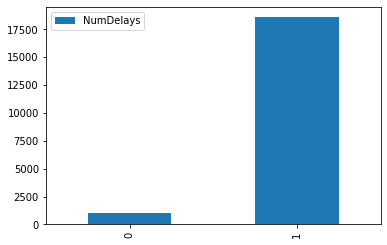

In [41]:
%matplotlib inline

spark.sql("""
SELECT
    UniqueCarrier,
    SUM(isDelayed_SQL(DepDelay)) AS NumDelays
FROM
    flightsView
GROUP BY
    UniqueCarrier
""").toPandas().plot.bar();

In [42]:
#
# Distancia recorrida por operador
#
spark.sql("""
SELECT
    UniqueCarrier,
    avg(Distance) AS AvgDistanceTraveled
FROM
    flightsView
GROUP BY
    UniqueCarrier
ORDER BY
    AvgDistanceTraveled DESC
""").show()

+-------------+-------------------+
|UniqueCarrier|AvgDistanceTraveled|
+-------------+-------------------+
|           XE|  738.0462651413189|
|           WN|  623.7926638668864|
+-------------+-------------------+



In [44]:
spark.sql("""
SELECT
    DayOfWeek,
    delayed,
    COUNT(1) AS Count
FROM
    (SELECT
        DayOfWeek,
        isDelayed_SQL(DepDelay) AS delayed
     FROM
        flightsView)
GROUP BY
    DayOfWeek,
    delayed
ORDER BY
    DayOfWeek, delayed
""").show()

+---------+-------+-----+
|DayOfWeek|delayed|Count|
+---------+-------+-----+
|        1|      0|11863|
|        1|      1| 2656|
|        2|      0|12910|
|        2|      1| 1799|
|        3|      0|13260|
|        3|      1| 1434|
|        4|      0|12271|
|        4|      1| 4808|
|        5|      0|11003|
|        5|      1| 3514|
|        6|      0| 9407|
|        6|      1| 1878|
|        7|      0| 9698|
|        7|      1| 3498|
+---------+-------+-----+



In [45]:
spark.sql("""
SELECT
    Hour,
    delayed,
    COUNT(1) AS Count
FROM
(
    SELECT
        CAST(CRSDepTime / 100 AS INT) AS Hour,
        isDelayed_SQL(DepDelay) AS delayed
    FROM
        flightsView
)
GROUP BY
    Hour, delayed
ORDER BY
    Hour, delayed
""").show()

+----+-------+-----+
|Hour|delayed|Count|
+----+-------+-----+
|   6|      0| 6126|
|   6|      1|  208|
|   7|      0| 7274|
|   7|      1|  372|
|   8|      0| 5956|
|   8|      1|  547|
|   9|      0| 5861|
|   9|      1|  761|
|  10|      0| 5783|
|  10|      1|  903|
|  11|      0| 5115|
|  11|      1|  986|
|  12|      0| 5174|
|  12|      1| 1128|
|  13|      0| 5225|
|  13|      1| 1346|
|  14|      0| 4434|
|  14|      1| 1335|
|  15|      0| 4818|
|  15|      1| 1562|
+----+-------+-----+
only showing top 20 rows



In [46]:
#
# Se salva la tabla calculada al directorio tmp del HDFS.
# Primero se borra si existe.
#
!hdfs dfs -rm -r -f /tmp/flightsWithDelays.orc

# Se salva en formato ORC
flightsWithDelays.write.format("orc").save("/tmp/flightsWithDelays.orc")

In [47]:
#
# Contenido del directorio donde se salvó la tabla
#
!hdfs dfs -ls /tmp/flightsWithDelays.orc

Found 4 items
-rw-r--r--   1 root supergroup          0 2022-11-22 11:45 /tmp/flightsWithDelays.orc/_SUCCESS
-rw-r--r--   1 root supergroup      89189 2022-11-22 11:45 /tmp/flightsWithDelays.orc/part-00000-42f2f3a0-39b4-4a6c-82cf-8669272e1bc0-c000.snappy.orc
-rw-r--r--   1 root supergroup     104992 2022-11-22 11:45 /tmp/flightsWithDelays.orc/part-00001-42f2f3a0-39b4-4a6c-82cf-8669272e1bc0-c000.snappy.orc
-rw-r--r--   1 root supergroup      34362 2022-11-22 11:45 /tmp/flightsWithDelays.orc/part-00002-42f2f3a0-39b4-4a6c-82cf-8669272e1bc0-c000.snappy.orc


In [54]:
#
# Se lee la tabla calculada desde el HDFS
#
test = spark.read.format("orc").load("/tmp/flightsWithDelays.orc")

# verifica la cantidad de registros.
assert test.count() == flightsWithDelays.count(), print("Archivos con diferentes tamaños.")

In [55]:
#
# La tabla queda guardada en la carpeta
# spark-warehouse del directorio actual
#
!rm -rf spark-warehouse/flightswithdelaystbl
flightsWithDelays.write.format("orc").saveAsTable("flightswithdelaystbl")

In [56]:
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|flightswithdelaystbl|      false|
|        |         flightsview|       true|
+--------+--------------------+-----------+



In [57]:
#
# Note que cuando la tabla está almacenada de forma
# permanente no es necesario cargarla a la memoria
# para poder usarla.
#
spark.sql("SELECT COUNT(1) AS Total from flightswithdelaystbl").show()

+-----+
|Total|
+-----+
|99999|
+-----+



In [58]:
# 
# Se borran las tablas para limpiar el área de trabajo.
#
spark.sql("DROP TABLE flightswithdelaystbl")
spark.sql("SHOW TABLES").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |flightsview|       true|
+--------+-----------+-----------+



In [ ]:
# 
# Toca limpieza
#
# !hdfs dfs -rm /tmp/flights.csv
# !rm flights* data.txt